In [1]:
import json
import string
from collections import defaultdict
from sklearn import linear_model
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
with open('winemag-data-130k-v2.json') as f:    
    data = json.load(f)
    
data = [d for d in data if d['price'] is not None and int(d['price']) <= 100]

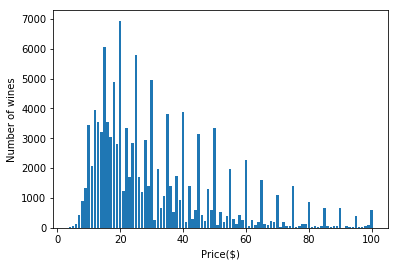

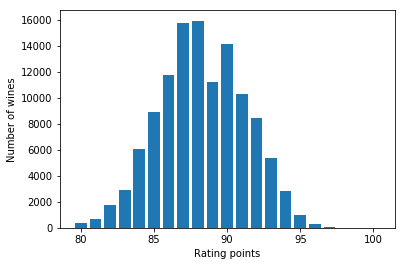

In [3]:
price_counts = defaultdict(int)
points_counts = defaultdict(int)

for d in data:
    price_counts[int(d['price'])] += 1
    points_counts[int(d['points'])] += 1
    
prices = sorted([(p, c) for p,c in price_counts.items()], key=lambda x: x[0])

plt.bar([p[0] for p in prices], [p[1] for p in prices])
plt.xlabel('Price($)')
plt.ylabel('Number of wines')
plt.show()

points = sorted([(p, c) for p,c in points_counts.items()], key=lambda x: x[0])
plt.bar([p[0] for p in points], [p[1] for p in points])
plt.xlabel('Rating points')
plt.ylabel('Number of wines')
plt.show()

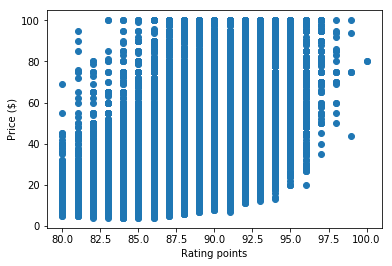

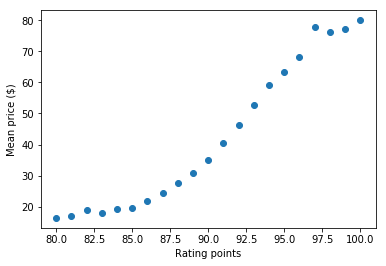

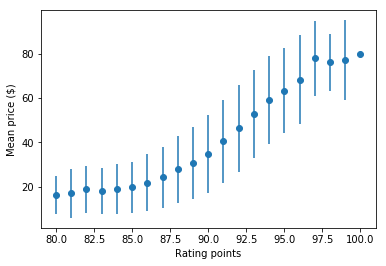

In [4]:
data_by_points = defaultdict(list)
for d in data:
    data_by_points[int(d['points'])].append(d)
    
avg_price_by_points = {k: sum([int(d['price']) for d in v])/len(v) for k,v in data_by_points.items()}
var_price_by_points = {k: math.sqrt(sum([(avg_price_by_points[k] - int(d['price']))**2 for d in v])/len(v)) for k,v in data_by_points.items()}

avg_price_by_points = sorted([(k, v) for k,v in avg_price_by_points.items()])
var_price_by_points = sorted([(k, v) for k,v in var_price_by_points.items()])

plt.scatter([int(d['points']) for d in data], [int(d['price']) for d in data])
plt.xlabel('Rating points')
plt.ylabel('Price ($)')
plt.show()

plt.scatter([p[0] for p in avg_price_by_points], [p[1] for p in avg_price_by_points])
plt.xlabel('Rating points')
plt.ylabel('Mean price ($)')
plt.show()

plt.errorbar([p[0] for p in avg_price_by_points],
             [p[1] for p in avg_price_by_points],
             yerr=[p[1] for p in var_price_by_points],
             fmt='o')
plt.xlabel('Rating points')
plt.ylabel('Mean price ($)')
plt.show()

In [5]:
word_count = defaultdict(int)
punctuation = set(string.punctuation)
digits = set(string.digits)
stop_words = set(stopwords.words('english'))
for d in data:
    r = ''.join([c for c in d['description'].lower() if c not in punctuation and c not in digits])
    for w in r.split():
        if w not in stop_words:
            word_count[w] += 1
            
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:2500]]
word_Id = dict(zip(words, range(len(words))))
word_set = set(words)

In [6]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['description'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[word_Id[w]] += 1
    feat.append(1) #offset
    return feat

In [7]:
provinces = set()
regions = set()
varieties = set()
wineries = set()


for d in data:
    provinces.add(d['province'])
    regions.add(d['region_1'])
    varieties.add(d['variety'])
    wineries.add(d['winery'])
    
    
province_dict = {p: i for p,i in zip(provinces, range(len(provinces)))}
region_dict = {r: i for r,i in zip(regions, range(len(regions)))}
variety_dict = {v: i for v,i in zip(varieties, range(len(varieties)))}
winery_dict = {w: i for w,i in zip(wineries, range(len(wineries)))}


In [8]:
def feature2(datum):
    feat = [0] * (len(provinces) + len(regions)+ len(varieties) + len(wineries)) + [1]
    feat[province_dict[datum['province']]] = 1
    feat[region_dict[datum['region_1']]+len(provinces)] = 1
    feat[variety_dict[datum['variety']]+len(provinces)+len(regions)] = 1
    feat[winery_dict[datum['winery']]+len(provinces)+len(regions)+len(varieties)] = 1
    return feat

In [9]:
#predict points
train = data[:len(data)//2]
valid = data[len(data)//2:]

X_train = [feature(d) for d in train]
y_train = [int(d['points']) for d in train]

X_valid = [feature(d) for d in valid]
y_valid = [int(d['points']) for d in valid]

In [10]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_valid)


In [11]:
mean = sum([int(d['points']) for d in data])/len(data)
variance = sum([(int(d['points']) - mean)**2 for d in data])/len(data)

print('Mean: ', mean, ' Variance: ', variance)

mse = sum([(x-y)**2 for x,y in zip(predictions, y_valid)])/len(predictions)
print('MSE: ', mse)

Mean:  88.29598925252319  Variance:  8.76226579709364
MSE:  3.11476853731


In [12]:
positive_words = sorted([(words[i], b) for i,b in enumerate(theta[:-1])], key=lambda x: x[1], reverse=True)
negative_words = sorted([(words[i], b) for i,b in enumerate(theta[:-1])], key=lambda x: x[1])

In [13]:
positive_words[:10]

[('brilliant', 1.6181918533551547),
 ('memorable', 1.6059659025854907),
 ('dazzling', 1.5635411094627936),
 ('spätlese', 1.4926312587567558),
 ('tremendous', 1.4813216089540175),
 ('umami', 1.4590164099568805),
 ('gorgeous', 1.3980232611880017),
 ('botrytis', 1.3933220063526268),
 ('study', 1.3870290693781535),
 ('immense', 1.3864573297144662)]

In [14]:
negative_words[:10]

[('strange', -1.8358772859172845),
 ('clumsy', -1.6425473710414782),
 ('watery', -1.5772753268595219),
 ('dull', -1.4444239633900435),
 ('unbalanced', -1.4393632492943353),
 ('mealy', -1.4098438804028257),
 ('lacks', -1.3940604349847066),
 ('harsh', -1.37899811697624),
 ('pickled', -1.3468433336554633),
 ('tired', -1.2888931427786663)]

In [15]:
#predict price
train = data[:len(data)//2]
valid = data[len(data)//2:]

X_train = [feature(d) for d in train]
y_train = [int(d['price']) for d in train]

X_valid = [feature(d) for d in valid]
y_valid = [int(d['price']) for d in valid]

In [16]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_valid)


In [17]:
mean = sum([int(d['price']) for d in data])/len(data)
variance = sum([(int(d['price']) - mean)**2 for d in data])/len(data)

print('Mean: ', mean, ' Variance: ', variance)

mse = sum([(x-y)**2 for x,y in zip(predictions, y_valid)])/len(predictions)
print('MSE: ', mse)

Mean:  31.085767245703984  Variance:  368.75961759551933
MSE:  231.870879743


In [18]:
positive_words = sorted([(words[i], b) for i,b in enumerate(theta[:-1])], key=lambda x: x[1], reverse=True)
negative_words = sorted([(words[i], b) for i,b in enumerate(theta[:-1])], key=lambda x: x[1])

In [19]:
positive_words[:10]

[('brunello', 20.197879200667757),
 ('champagne', 19.471150265970742),
 ('barolo', 19.275686422059565),
 ('amarone', 17.275469408989505),
 ('pommard', 15.78444053962658),
 ('premier', 13.649803876106713),
 ('dosage', 12.032407692397298),
 ('grand', 9.2362177613728917),
 ('longterm', 9.1222246848662909),
 ('immense', 9.0658967940918043)]

In [20]:
negative_words[:10]

[('valuepriced', -12.177902518867318),
 ('buy', -10.466490762408778),
 ('value', -10.196018315563983),
 ('bargain', -9.8249506878937893),
 ('arinto', -9.1270827589771848),
 ('columbia', -9.0153760525427646),
 ('affordable', -8.9420453944699627),
 ('dão', -8.5743672419770025),
 ('price', -8.0731058933542457),
 ('wellpriced', -7.9677631543858896)]